In [1]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np

# Para Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer # Para tratar dados faltantes

In [2]:
import pandas as pd
import numpy as np

# 1. Definir os Nomes das Colunas (Padrão CMAPSS)
# O dataset tem 26 colunas: 1 ID, 1 Ciclo, 3 Configurações Operacionais, 21 Leituras de Sensores.
colunas = ['id_motor', 'ciclo'] + \
          [f'config_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]

# 2. Carregar o Arquivo PM_train.txt
df_train = pd.read_csv(
    'PM_train.txt',
    sep='\s+',           # Separador de espaços em branco (padrão do arquivo)
    header=None,         # O arquivo não tem cabeçalho
    names=colunas,       # Usar os nomes de colunas definidas
    index_col=False
)

# Remover a última coluna vazia que o Pandas cria devido a espaços no final
df_train.drop(columns=[colunas[-1]], inplace=True)
print("Dados carregados. Primeiras 5 linhas:")
print(df_train.head())
print("\nTipos de dados:")
print(df_train.info())

Dados carregados. Primeiras 5 linhas:
   id_motor  ciclo  config_1  config_2  config_3  sensor_1  sensor_2  \
0         1      1   -0.0007   -0.0004     100.0    518.67    641.82   
1         1      2    0.0019   -0.0003     100.0    518.67    642.15   
2         1      3   -0.0043    0.0003     100.0    518.67    642.35   
3         1      4    0.0007    0.0000     100.0    518.67    642.35   
4         1      5   -0.0019   -0.0002     100.0    518.67    642.37   

   sensor_3  sensor_4  sensor_5  ...  sensor_11  sensor_12  sensor_13  \
0   1589.70   1400.60     14.62  ...      47.47     521.66    2388.02   
1   1591.82   1403.14     14.62  ...      47.49     522.28    2388.07   
2   1587.99   1404.20     14.62  ...      47.27     522.42    2388.03   
3   1582.79   1401.87     14.62  ...      47.13     522.86    2388.08   
4   1582.85   1406.22     14.62  ...      47.28     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  
0    8138

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-4072981913.py:14: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',           # Separador de espaços em branco (padrão do arquivo)


In [3]:
# Achar o Ciclo Máximo (Falha) para cada Motor
df_max_ciclo = df_train.groupby('id_motor')['ciclo'].max().reset_index()
df_max_ciclo.columns = ['id_motor', 'max_ciclo']

# 1. Calcular o RUL (Remaining Useful Life)
df_train = df_train.merge(df_max_ciclo, on='id_motor', how='left')
df_train['rul'] = df_train['max_ciclo'] - df_train['ciclo']

# 2. Criar o Rótulo Binário (0 = Normal, 1 = Falha/Anomalia Iminente)
# Vamos usar um Limite (Threshold) de 30 ciclos para definir a 'falha'
RUL_THRESHOLD = 30
df_train['label_falha'] = np.where(df_train['rul'] <= RUL_THRESHOLD, 1, 0)

print(f"\nDistribuição do Rótulo Binário (Limite RUL <= {RUL_THRESHOLD} ciclos):")
print(df_train['label_falha'].value_counts())
print("\nLinhas com Rótulo Criado (colunas 'rul' e 'label_falha'):")
print(df_train[['id_motor', 'ciclo', 'rul', 'label_falha']].tail())


Distribuição do Rótulo Binário (Limite RUL <= 30 ciclos):
label_falha
0    17531
1     3100
Name: count, dtype: int64

Linhas com Rótulo Criado (colunas 'rul' e 'label_falha'):
       id_motor  ciclo  rul  label_falha
20626       100    196    4            1
20627       100    197    3            1
20628       100    198    2            1
20629       100    199    1            1
20630       100    200    0            1


In [4]:
# 1. Separar o Rótulo (Target) das Features (X)
TARGET_COLUMN = 'label_falha'
y = df_train[TARGET_COLUMN]

# 2. Remover colunas não-features ou irrelevantes
colunas_a_remover = [
    'id_motor', 'ciclo', 'max_ciclo', 'rul', TARGET_COLUMN,
    'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'
]
X = df_train.drop(columns=colunas_a_remover)

print(f"\nFeatures (X) selecionadas ({X.shape[1]} colunas):")
print(X.columns.tolist())


Features (X) selecionadas (16 colunas):
['config_1', 'config_2', 'config_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20']


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Importar imputer

# 1. Imputação Simples (Garantia de segurança, se houver Nulos)
# Se houver Nulos, preenche com a Mediana
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 2. Escalonamento (Padronização)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transformar de volta para DataFrame para consistência
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nVerificação de Nulos (deve ser 0):", X_scaled_df.isnull().sum().sum())
print("Features prontas para a divisão Treino/Teste.")


Verificação de Nulos (deve ser 0): 0
Features prontas para a divisão Treino/Teste.


In [6]:
from sklearn.model_selection import train_test_split

# Dividir 80% para Treino e 20% para Teste (Dados já escalonados e com rótulo binário)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df,      # Features escalonadas
    y,                # Rótulos binários
    test_size=0.2,    # 20% para teste
    random_state=42,  # Para resultados reprodutíveis
    stratify=y        # Garante a mesma proporção de Normal/Falha em ambos os conjuntos
)

print(f"\n--- FASE 2 CONCLUÍDA ---")
print(f"Conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras")


--- FASE 2 CONCLUÍDA ---
Conjunto de Treino: 16504 amostras
Conjunto de Teste: 4127 amostras


In [7]:
# Importar o modelo Random Forest
from sklearn.ensemble import RandomForestClassifier

# Importar métricas de avaliação (serão usadas na próxima fase, mas já as importamos)
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [8]:
# Instanciar o modelo Random Forest
# n_estimators=100 significa que o modelo usará 100 Árvores de Decisão
# random_state=42 garante que os resultados sejam os mesmos sempre
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

print("Modelo Random Forest criado com sucesso!")

Modelo Random Forest criado com sucesso!


In [9]:
# Treinar o modelo
# Esta linha é o coração do Machine Learning supervisionado
print("Iniciando treinamento...")
modelo_rf.fit(X_train, y_train)
print("Treinamento concluído com sucesso!")

Iniciando treinamento...
Treinamento concluído com sucesso!


In [10]:
# Fazer previsões no conjunto de teste (os dados que o modelo nunca viu)
y_pred = modelo_rf.predict(X_test)

print("Previsões geradas no conjunto de teste. Variável 'y_pred' está pronta para avaliação.")

Previsões geradas no conjunto de teste. Variável 'y_pred' está pronta para avaliação.


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Acurácia (Accuracy)
# Medida geral de acertos: (Corretos) / (Total)
acuracia = accuracy_score(y_test, y_pred)

# 2. Precisão (Precision)
# Dos que o modelo previu como Falha (1), quantos estavam realmente em Falha?
precisao = precision_score(y_test, y_pred)

# 3. Recall (Revocação)
# Das Falhas reais existentes, quantas o modelo conseguiu DETECTAR?
recall = recall_score(y_test, y_pred)

# 4. F1-Score
# Média harmônica entre Precisão e Recall. Bom resumo de performance.
f1 = f1_score(y_test, y_pred)

print(f"--- Métricas de Desempenho ---")
print(f"Acurácia Geral: {acuracia:.4f}")
print(f"Precisão (Classe Falha=1): {precisao:.4f}")
print(f"Recall (Classe Falha=1): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

--- Métricas de Desempenho ---
Acurácia Geral: 0.9639
Precisão (Classe Falha=1): 0.8880
Recall (Classe Falha=1): 0.8694
F1-Score: 0.8786


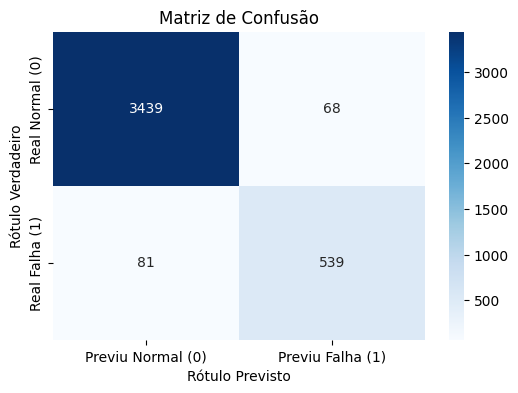

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Gerar a matriz de confusão
matriz_conf = confusion_matrix(y_test, y_pred)

# Visualizar a matriz
plt.figure(figsize=(6, 4))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previu Normal (0)', 'Previu Falha (1)'],
            yticklabels=['Real Normal (0)', 'Real Falha (1)'])
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.title('Matriz de Confusão')
plt.show() # Exibe o gráfico no Colab

In [13]:
from sklearn.ensemble import RandomForestClassifier

# 1. Instanciar o modelo AGORA com o class_weight='balanced'
# Isso forçará o modelo a dar mais peso à classe minoritária ('Falha')
modelo_rf_melhorado = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # <--- A MÁGICA DA OTIMIZAÇÃO PARA DESBALANCEAMENTO
)

print("Iniciando Retreinamento com Ajuste de Peso de Classes...")
# 2. Retreinar o modelo
modelo_rf_melhorado.fit(X_train, y_train)
print("Retreinamento concluído!")

# 3. Refazer as previsões
y_pred_melhorado = modelo_rf_melhorado.predict(X_test)

Iniciando Retreinamento com Ajuste de Peso de Classes...
Retreinamento concluído!



--- NOVAS MÉTRICAS DE DESEMPENHO ---
Acurácia Geral: 0.9634
Precisão (Classe Falha=1): 0.8954
Recall (Classe Falha=1): 0.8565


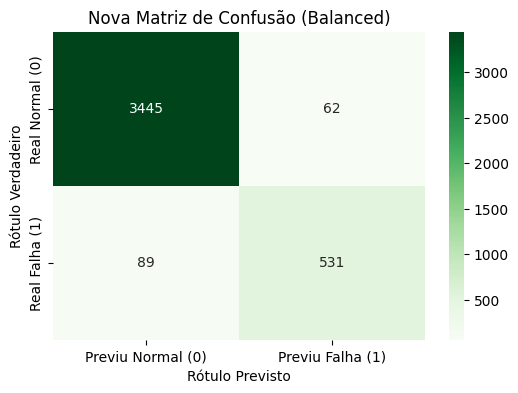

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular Novas Métricas
acuracia_n = accuracy_score(y_test, y_pred_melhorado)
precisao_n = precision_score(y_test, y_pred_melhorado)
recall_n = recall_score(y_test, y_pred_melhorado)

print(f"\n--- NOVAS MÉTRICAS DE DESEMPENHO ---")
print(f"Acurácia Geral: {acuracia_n:.4f}")
print(f"Precisão (Classe Falha=1): {precisao_n:.4f}")
print(f"Recall (Classe Falha=1): {recall_n:.4f}")

# Gerar a Nova Matriz de Confusão
matriz_conf_n = confusion_matrix(y_test, y_pred_melhorado)

plt.figure(figsize=(6, 4))
sns.heatmap(matriz_conf_n, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previu Normal (0)', 'Previu Falha (1)'],
            yticklabels=['Real Normal (0)', 'Real Falha (1)'])
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.title('Nova Matriz de Confusão (Balanced)')
plt.show()